In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.settings import Config
from src.utils import Network, Results, FineNetwork, CoarseNetwork, haversine_matrix
from src.models import SpatialAggregation, TemporalAggregation
from src.visualization import Visualizer
from src.main import StaticPreprocessor, DynamicProcessor
from src.gtep import read_data, GTEPBase, AggregatedGTEP, SpatialGTEP, TemporalGTEP

import pickle
import xarray as xr
import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from gurobipy import GRB

# Full pipeline

In [32]:
# Static preprocessing (run once)
static_prep = StaticPreprocessor(granularity="fine").preprocess()

# Dynamic processor (reused for multiple runs)
processor = DynamicProcessor(static_prep)

res, version_hash, day_weights, res_meta = processor.run_with_hyperparameters(
    weights={
        'position': 1.0,
        'time_series': 0.8,
        'duration_curves': 1.2,
        'ramp_duration_curves': 1.0,
        'intra_correlation': 1.0,
        'inter_correlation': 1.0
    },
    n_representative_nodes=17,
    k_representative_days=5
)

# # Define parameter grid
# param_grid = {
#     'weights': [
#         {'position': 1.0, 'time_series': 0.8, 'duration_curves': 1.2},
#         {'position': 0.8, 'time_series': 1.0, 'duration_curves': 1.0}
#     ],
#     'n_representative_nodes': [10, 15],
#     'k_representative_days': [8, 10]
# }

# # Execute grid search
# results = {}
# for params in ParameterGrid(param_grid):
#     res, version_hash = processor.run_with_hyperparameters(
#         weights=params['weights'],
#         n_representative_nodes=params['n_representative_nodes'],
#         k_representative_days=params['k_representative_days']
#     )
#     results[version_hash] = {'params': params, 'results': res}

c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\src\utils.py:143: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.y,
c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\src\utils.py:144: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.x


Cached metrics loaded from c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\distance_metrics\v6cdfff21.
Results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\joint_aggregation_results\v4e56a163


In [33]:
res_meta["temporal_clusters"]["representatives"]

[10, 88, 176, 300, 339]

In [ ]:
zone_path = PROJECT_ROOT / "DATA" / "raw" / "17_zones"
zones_df = pd.read_csv(zone_path / "17_Nodes.csv")
zones_df['Lon'] = -zones_df['Lon']
nodes_df = processor.preprocessor.network_data["nodes"]

In [12]:
zones_df[['Lat', 'Lon']].values

array([[ 42.642711  , -70.865107  ],
       [ 42.479477  , -71.396507  ],
       [ 42.33196   , -71.020173  ],
       [ 42.169703  , -71.179875  ],
       [ 41.6442816 , -70.5767066 ],
       [ 42.311693  , -71.940282  ],
       [ 42.3586905 , -72.77623625],
       [ 44.95841783, -69.25041192],
       [ 43.8299905 , -70.2630515 ],
       [ 44.16137386, -72.68527314],
       [ 42.9505015 , -71.411269  ],
       [ 43.605611  , -71.6181295 ],
       [ 41.6314806 , -71.4682568 ],
       [ 41.228103  , -73.366757  ],
       [ 41.570807  , -73.067816  ],
       [ 41.806053  , -72.732916  ],
       [ 41.6490575 , -72.2398395 ]])

In [27]:
def assign_zones_and_get_representatives(nodes_df, zones_df):
    # Extract node and zone coordinates
    node_coords = nodes_df[['Lat', 'Lon']].values
    zone_coords = zones_df[['Lat', 'Lon']].values
    
    # Number of nodes and zones
    n_nodes = node_coords.shape[0]
    n_zones = zone_coords.shape[0]
    
    # Initialize distance matrix
    dist_matrix = haversine_matrix(node_coords, zone_coords)
    print("Distance matrix shape:", dist_matrix.shape)
    
    # Assign each node to the closest zone
    closest_zone_indices = np.argmin(dist_matrix, axis=1)
    nodes_df['zone_index'] = closest_zone_indices
    
    # Prepare the result dictionary
    dict = {}
    dict["clusters"] = {}
    dict["representatives"] = []
    
    # Process each zone
    for zone_idx in range(n_zones):
        # Indices of nodes in the current zone
        node_indices_in_zone = nodes_df.index[nodes_df['zone_index'] == zone_idx].tolist()
        
        # Skip if no nodes in the zone
        if not node_indices_in_zone:
            print(f"No nodes found in zone {zone_idx}. Skipping.")
            continue
        
        # Distances from nodes in the zone to the zone center
        distances_to_zone_center = dist_matrix[node_indices_in_zone, zone_idx]
        
        # Find the node closest to the zone center
        min_idx_in_subset = np.argmin(distances_to_zone_center)
        representative_node_idx = node_indices_in_zone[min_idx_in_subset]
        representative_bus_id = nodes_df.index[representative_node_idx]
        dict["representatives"].append(representative_bus_id)
        
        # Add to result dictionary
        dict["clusters"][representative_bus_id] = node_indices_in_zone
    
    result_dict = {
        "representatives": sorted(dict["representatives"]),
        "clusters": {
            k: sorted(dict["clusters"][k]) for k in sorted(dict["representatives"])
        }
    }
    
    if sum(len(v) for v in result_dict["clusters"].values()) != len(nodes_df):
        raise ValueError("Mismatch in total nodes assigned to zones.")
    
    return result_dict

In [28]:
zone_mapping = assign_zones_and_get_representatives(nodes_df, zones_df)

Distance matrix shape: (385, 17)


In [30]:
zone_mapping["representatives"]
zone_mapping["clusters"]

{2: [0, 1, 2, 3],
 10: [4, 5, 8, 9, 10, 11, 19, 20, 34],
 13: [6, 7, 12, 13, 14, 15, 24, 25, 26, 39],
 22: [21, 22, 23, 35, 36, 37, 38],
 28: [16, 17, 27, 28, 29, 42],
 32: [18, 30, 31, 32, 33, 46],
 57: [43, 44, 45, 56, 57],
 58: [58, 59],
 62: [47,
  48,
  49,
  50,
  51,
  60,
  61,
  62,
  63,
  70,
  71,
  72,
  73,
  82,
  83,
  84,
  85,
  93,
  94,
  95,
  96],
 66: [40, 41, 52, 53, 54, 55, 64, 65, 66, 74, 75, 76, 86],
 68: [67, 68, 69, 77, 78, 79],
 81: [80, 81, 92, 104],
 90: [87, 88, 89, 90, 91, 97, 98, 99, 100, 101, 102, 103, 114, 115, 116],
 124: [108,
  109,
  110,
  111,
  112,
  113,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  135,
  136,
  137,
  138,
  139,
  140,
  151,
  152,
  153,
  154,
  169,
  170,
  171,
  189,
  190],
 143: [128,
  129,
  141,
  142,
  143,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  191,
  192,
  193,
  194,
  195,
  196,
  212,
  213,
  214,
  215,
  216,
  239,
  240,
  

In [35]:
zonal = Results(config=processor.preprocessor.config, data=processor.preprocessor.network_data, spatial_agg_results=zone_mapping, temporal_agg_results=res_meta["temporal_clusters"], auto_save= False)

In [37]:
zonal.results["spatiotemporal"]

{'nodes':       Lat    Lon  bus_id
 0   41.32 -73.40       2
 1   41.54 -72.96      10
 2   41.54 -72.30      13
 3   41.76 -72.74      22
 4   41.76 -71.42      28
 5   41.76 -70.54      32
 6   42.20 -71.20      57
 7   42.20 -70.98      58
 8   42.42 -72.74      62
 9   42.42 -71.86      66
 10  42.42 -71.42      68
 11  42.64 -70.76      81
 12  42.86 -71.42      90
 13  43.52 -71.64     124
 14  43.74 -70.32     143
 15  44.18 -72.74     164
 16  45.06 -69.22     269,
 'branches':      branch_id  from_bus_id  to_bus_id
 0            0          2.0       10.0
 1            1          2.0       13.0
 2            2          2.0       22.0
 3            3          2.0       28.0
 4            4          2.0       32.0
 ..         ...          ...        ...
 267        267        269.0       81.0
 268        268        269.0       90.0
 269        269        269.0      124.0
 270        270        269.0      143.0
 271        271        269.0      164.0
 
 [272 rows x 3 columns],
 't

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from math import radians, sin, cos, sqrt, asin

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6371 * c
    return km

# Assuming nodes_df and path_to_folder are provided
def get_state_representative_nodes(nodes_df, path_to_folder):
    state_gdf = gpd.read_file(f"{path_to_folder}/cb_2022_us_state_500k.shp")
    ne_states = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']
    state_gdf = state_gdf[state_gdf['STUSPS'].isin(ne_states)]
    
    geometry = [Point(lon, lat) for lon, lat in zip(nodes_df['Lon'], nodes_df['Lat'])]
    gdf_nodes = gpd.GeoDataFrame(nodes_df, geometry=geometry, crs=state_gdf.crs)
    
    gdf_joined = gpd.sjoin(gdf_nodes, state_gdf, how='left', predicate='intersects')
    
    if gdf_joined['STUSPS'].isnull().any():
        missing_count = gdf_joined['STUSPS'].isnull().sum()
        raise ValueError(f"{missing_count} nodes are not within any state boundary.")
    
    if gdf_joined.index.duplicated().any():
        gdf_joined = gdf_joined[~gdf_joined.index.duplicated(keep='first')]
    
    state_gdf['centroid'] = state_gdf.geometry.centroid
    state_centroids = state_gdf.set_index('STUSPS')['centroid']
    
    grouped = gdf_joined.groupby('STUSPS')
    result_dict = {}
    
    for state_code, group in grouped:
        centroid_point = state_centroids.loc[state_code]
        centroid_lon, centroid_lat = centroid_point.x, centroid_point.y
        
        min_dist = float('inf')
        rep_bus_id = None
        
        for idx, row in group.iterrows():
            dist = haversine(centroid_lon, centroid_lat, row['Lon'], row['Lat'])
            if dist < min_dist:
                min_dist = dist
                rep_bus_id = row['bus_id']
        
        bus_ids_in_state = group['bus_id'].tolist()
        result_dict[rep_bus_id] = bus_ids_in_state
    
    return result_dict

In [40]:
def data_cb(model, where):
    if where == gp.GRB.Callback.MIP:
        cur_obj = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
        cur_bd = model.cbGet(gp.GRB.Callback.MIP_OBJBND)

        # Did objective value or best bound change?
        if model._obj != cur_obj or model._bd != cur_bd:
            model._obj = cur_obj
            model._bd = cur_bd
            model._data.append([time.time() - model._start, cur_obj, cur_bd])
            pd.DataFrame(model._data).to_csv('full_solve_log.csv')

def run_agg_gtep(agg_results, day_weights):
    """
    Run the GTEP model with the provided aggregated results and representative days weights.
    """
    # Read data from the aggregated results
    buses, branches, load, pv, wind, params = read_data(agg_results["spatiotemporal"])
    day_weigths_list = list(day_weights.values())

    data = [buses, branches]
    eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
    for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
        params[key] = params[key] * 1e-5

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        gtep = AggregatedGTEP(env, data, params)
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        cep_results = gtep.solve(eval_period, day_weigths_list, callback=data_cb)

        return cep_results, params

def run_spatial_gtep(agg_results, day_weights, aggregated_gtep_results, sptial_agg_results):
    """
    Run the Spatial GTEP model with the provided aggregated results and representative days weights.
    """
    buses, branches, load, pv, wind, params = read_data(agg_results["temporal_only"])
    day_weigths_list = list(day_weights.values())

    data = [buses, branches]
    eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
    for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
        params[key] = params[key] * 1e-5

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        gtep = SpatialGTEP(env, data, params, aggregated_gtep_results, sptial_agg_results, agg_results["spatiotemporal"]["branches"])
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        cep_results = gtep.solve(eval_period, day_weigths_list, callback=data_cb)

        return cep_results, params
    
def run_temporal_gtep(agg_results, investment_results):
    """
    Run the Temporal GTEP model with the provided aggregated results and representative days weights.
    """
    buses, branches, load, pv, wind, params = read_data(agg_results["original"])

    data = [buses, branches]
    eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
    for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
        params[key] = params[key] * 1e-5

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        gtep = TemporalGTEP(env, data, params, investment_results)
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        number_of_days = len(eval_period['Load']) // 24
        day_weights = [1/number_of_days]*number_of_days
        cep_results = gtep.solve(eval_period, day_weights, callback=data_cb)

        return cep_results, params

In [41]:
res_zonal = {}
res_zonal["spatiotemporal"] = zonal.results["spatiotemporal"]
agg_cep_results, agg_params = run_agg_gtep(res_zonal, day_weights)

PV shape  (120, 17)
Wind shape  (120, 17)
Load shape  (120, 17)
Data loaded successfully.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 120531 rows, 45237 columns and 345682 nonzeros
Model fingerprint: 0x47d590d6
Variable types: 45220 continuous, 17 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-04, 2e+03]
  Objective range  [8e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 5e+05]
Found heuristic solution: objective 3615451.8643
Presolve removed 26552 rows and 23307 columns
Presolve time: 0.77s
Presolved: 93979 rows, 21930 columns, 249143 nonzeros
Found heuristic solution: objective 1825093.7062
Variable types: 21913 continuous, 17 i

In [42]:
agg_cep_results_2, agg_params_2 = run_agg_gtep(res, day_weights)

PV shape  (120, 17)
Wind shape  (120, 17)
Load shape  (120, 17)
Data loaded successfully.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 120531 rows, 45237 columns and 345554 nonzeros
Model fingerprint: 0x824b1509
Variable types: 45220 continuous, 17 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [8e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 5e+05]
Found heuristic solution: objective 3456921.8350
Presolve removed 26552 rows and 23307 columns
Presolve time: 0.43s
Presolved: 93979 rows, 21930 columns, 249015 nonzeros
Found heuristic solution: objective 1854755.6313
Variable types: 21913 continuous, 17 i

In [45]:
save_cep_results(agg_cep_results, agg_params, version_hash, 1, "17_zones")

CEP results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\cep_output\agg_cep_results_4e56a163_17_zones.pkl


In [46]:
save_cep_results(agg_cep_results_2, agg_params_2, version_hash, 1,)

CEP results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\cep_output\agg_cep_results_4e56a163.pkl


In [44]:
def save_cep_results(cep_results, params, version_hash, tag, name=None):
    """
    Save the CEP results and parameters to a file.
    """
    if tag == 1:
        name_cep_results = 'agg_cep_results'
    elif tag == 2:
        name_cep_results = 'spatial_cep_results'
    elif tag == 3:
        name_cep_results = 'temporal_cep_results'
    if name:
        output_path = PROJECT_ROOT / 'results' / 'cep_output' / f"{name_cep_results}_{version_hash}_{name}.pkl"
    else:
        output_path = PROJECT_ROOT / 'results' / 'cep_output' / f'{name_cep_results}_{version_hash}.pkl'
    with open(output_path, 'wb') as f:
        pickle.dump({'results': cep_results, 'params': params}, f)
    print(f"CEP results saved to {output_path}")

def load_cep_results(version_hash, tag, name=None):
    """
    Load the CEP results and parameters from a file.
    """
    if tag == 1:
        name_cep_results = 'agg_cep_results'
    elif tag == 2:
        name_cep_results = 'spatial_cep_results'
    elif tag == 3:
        name_cep_results = 'temporal_cep_results'
    if name:
        input_path = PROJECT_ROOT / 'results' / 'cep_output' / f"{name_cep_results}_{version_hash}_{name}.pkl"
    else:
        input_path = PROJECT_ROOT / 'results' / 'cep_output' / f'{name_cep_results}_{version_hash}.pkl'
    with open(input_path, 'rb') as f:
        data = pickle.load(f)
    print(f"CEP results loaded from {input_path}")
    return data['results'], data['params']

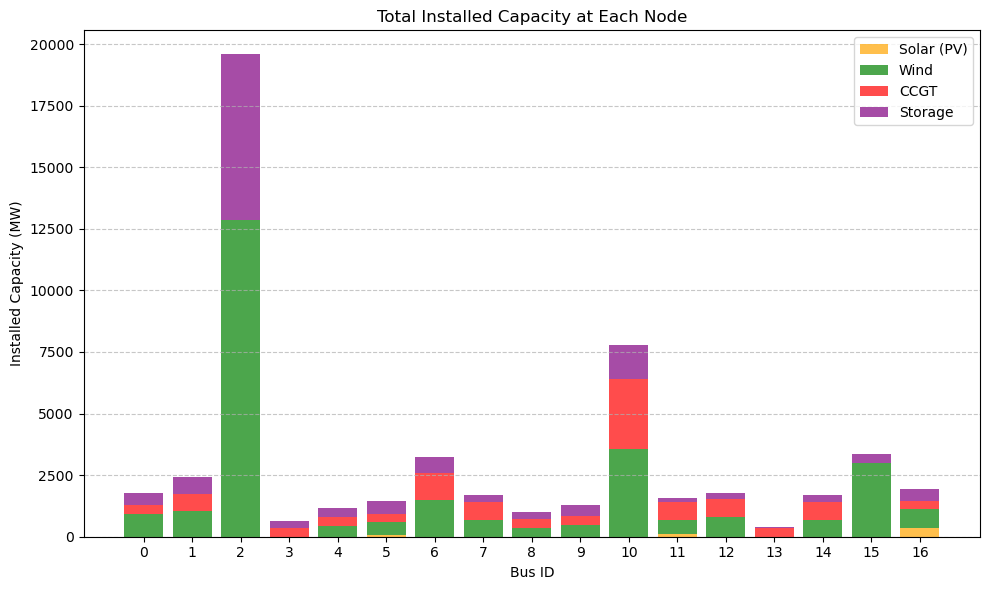

In [50]:
# Extract investments from the loaded results
pv_investment = np.array(list(agg_cep_results["inv"]["PV"].values()))
wind_investment = np.array(list(agg_cep_results["inv"]["Wind"].values()))
ccgt_investment = np.array(list(agg_cep_results["inv"]["CCGT"].values())) * agg_params['CCGT Max Cap']
storage_investment = np.array(list(agg_cep_results["inv"]["Storage Power"].values()))

# Calculate total capacity installed at each bus
# total_capacity = pv_investment + wind_investment + ccgt_investment + storage_investment

# Create a bar plot
bus_ids = range(len(pv_investment))  # Assuming buses are indexed from 0 to N-1
plt.figure(figsize=(10, 6))
# plt.bar(bus_ids, total_capacity, color='skyblue', label='Total Capacity (MW)')

# Add labels for individual components
plt.bar(bus_ids, pv_investment, color='orange', label='Solar (PV)', alpha=0.7)
plt.bar(bus_ids, wind_investment, bottom=pv_investment, color='green', label='Wind', alpha=0.7)
plt.bar(bus_ids, ccgt_investment, bottom=pv_investment + wind_investment, color='red', label='CCGT', alpha=0.7)
plt.bar(bus_ids, storage_investment, bottom=pv_investment + wind_investment + ccgt_investment, color='purple', label='Storage', alpha=0.7)

# Add plot details
plt.xlabel('Bus ID')
plt.ylabel('Installed Capacity (MW)')
plt.title('Total Installed Capacity at Each Node')
plt.xticks(bus_ids)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('installed_capacity.png', dpi=300)

# Show the plot
plt.show()

In [56]:
agg_cep_results["objective"]

20236.90410045154

In [57]:
agg_cep_results_2["objective"]

21113.145144791775

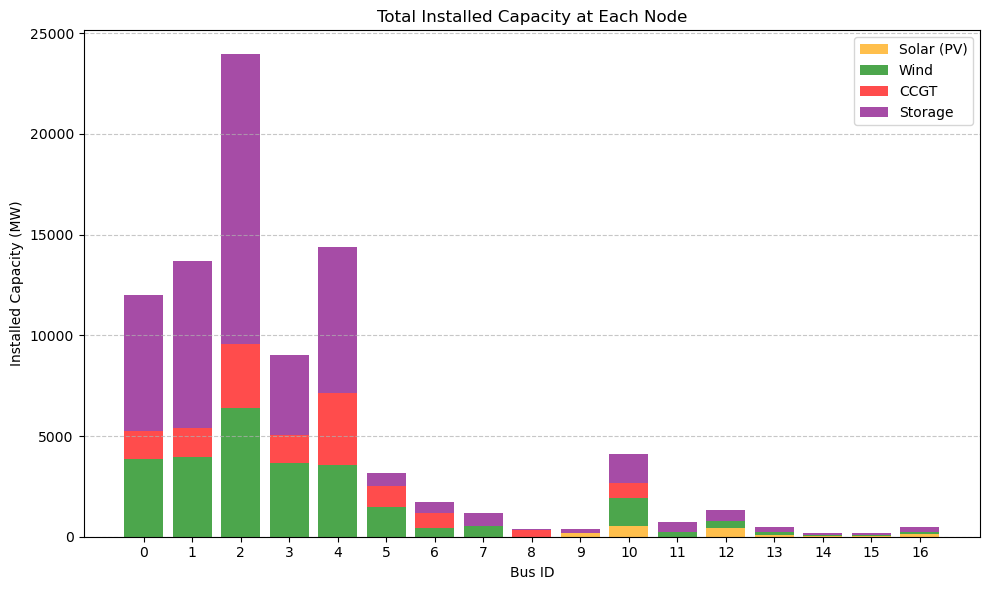

In [48]:
# Extract investments from the loaded results
pv_investment = np.array(list(agg_cep_results_2["inv"]["PV"].values()))
wind_investment = np.array(list(agg_cep_results_2["inv"]["Wind"].values()))
ccgt_investment = np.array(list(agg_cep_results_2["inv"]["CCGT"].values())) * agg_params_2['CCGT Max Cap']
storage_investment = np.array(list(agg_cep_results_2["inv"]["Storage Energy"].values()))

# Calculate total capacity installed at each bus
# total_capacity = pv_investment + wind_investment + ccgt_investment + storage_investment

# Create a bar plot
bus_ids = range(len(pv_investment))  # Assuming buses are indexed from 0 to N-1
plt.figure(figsize=(10, 6))
# plt.bar(bus_ids, total_capacity, color='skyblue', label='Total Capacity (MW)')

# Add labels for individual components
plt.bar(bus_ids, pv_investment, color='orange', label='Solar (PV)', alpha=0.7)
plt.bar(bus_ids, wind_investment, bottom=pv_investment, color='green', label='Wind', alpha=0.7)
plt.bar(bus_ids, ccgt_investment, bottom=pv_investment + wind_investment, color='red', label='CCGT', alpha=0.7)
plt.bar(bus_ids, storage_investment, bottom=pv_investment + wind_investment + ccgt_investment, color='purple', label='Storage', alpha=0.7)

# Add plot details
plt.xlabel('Bus ID')
plt.ylabel('Installed Capacity (MW)')
plt.title('Total Installed Capacity at Each Node')
plt.xticks(bus_ids)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('installed_capacity.png', dpi=300)

# Show the plot
plt.show()

In [12]:
res["time_series"]["wind"]

,55,121,263,305
240,1.000000,1.000000,0.109649,1.000000
241,1.000000,0.344426,0.300061,0.372896
242,1.000000,0.198136,0.633397,0.703695
243,1.000000,0.097368,0.841384,0.480587
244,0.550976,0.068622,0.573918,0.124052
...,...,...,...,...
8155,0.165320,0.219833,0.281343,0.741242
8156,0.149221,0.298068,0.054544,0.616355
8157,0.606175,0.970433,0.078919,0.355297
8158,0.597525,0.539192,0.081498,0.693879
